In [1]:
from agents import DPM_Agent, agent_loss, agent_training_loss, sampled_agent_reward
from trading_env.environment import TradingEnv

In [2]:
import dill
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


In [3]:
yf_file = "./data/archive_data/yf_data.dill"
with open(yf_file,'rb') as dill_file:
    yf_df = dill.load(dill_file)
    

In [4]:
print('Head of data set:')
yf_df.head()

Head of data set:


,Date,Symbol,high,low,open,close,volume,adjclose
0,2000-01-03,MMM,48.25000,47.03125,48.03125,47.1875,2173400,27.387001
1,2000-01-04,MMM,47.40625,45.31250,46.43750,45.3125,2713800,26.298779
2,2000-01-05,MMM,48.12500,45.56250,45.56250,46.6250,3699400,27.060537
3,2000-01-06,MMM,51.25000,47.15625,47.15625,50.3750,5975800,29.236986
4,2000-01-07,MMM,51.90625,49.96875,50.56250,51.3750,4101200,29.817362


In [5]:
print('Tail of data set:')
yf_df.tail()

Tail of data set:


,Date,Symbol,high,low,open,close,volume,adjclose
861287,2020-12-24,YUM,107.690002,106.940002,107.220001,107.540001,340400,106.582886
861288,2020-12-28,YUM,109.849998,107.379997,108.489998,109.779999,1822900,108.802956
861289,2020-12-29,YUM,110.559998,109.400002,109.629997,109.449997,1818300,108.475891
861290,2020-12-30,YUM,110.660004,109.330002,109.349998,109.510002,1267900,108.535355
861291,2020-12-31,YUM,109.180000,107.379997,108.739998,108.559998,1651700,107.593803


Each line of the dataframe contains the values of a single symbol for a single day. 

We only keep use the columns high, low, open, close, and volume. We normalize the volume column here.

In [6]:
# Generate array of symbols in the yf dataframe
symbols = yf_df['Symbol'].unique()

# Create list of dataframes for each symbol
print(symbols)

['MMM' 'ABT' 'ADBE' 'AES' 'AFL' 'APD' 'ALL' 'MO' 'AEE' 'AEP' 'AXP' 'AIG'
 'AMGN' 'ADI' 'AON' 'APA' 'AAPL' 'AMAT' 'ADM' 'T' 'ADSK' 'ADP' 'AZO' 'AVY'
 'BLL' 'BAC' 'BBWI' 'BAX' 'BDX' 'BBY' 'BK' 'BA' 'BSX' 'BMY' 'CPB' 'COF'
 'CAH' 'CCL' 'CAT' 'CNP' 'SCHW' 'CVX' 'CI' 'CINF' 'CSCO' 'C' 'CTXS' 'CLX'
 'CMS' 'KO' 'CL' 'CMA' 'CAG' 'COP' 'COST' 'CSX' 'CMI' 'CVS' 'DE' 'DOV'
 'DTE' 'DUK' 'EMN' 'ECL' 'EIX' 'EMR' 'ETR' 'EFX' 'EXC' 'XOM' 'FDX' 'F'
 'GPS' 'GD' 'GIS' 'GPC' 'GL' 'GWW' 'HAL' 'HIG' 'HAS' 'HSY' 'HES' 'HD'
 'HON' 'HWM' 'HPQ' 'ITW' 'INTC' 'IBM' 'IP' 'IPG' 'IFF' 'JNJ' 'JPM' 'K'
 'KEY' 'KMB' 'KR' 'LEG' 'LLY' 'LNC' 'LIN' 'LMT' 'LOW' 'LUMN' 'MRO' 'MMC'
 'MAS' 'MCD' 'MDT' 'MRK' 'MU' 'MSFT' 'TAP' 'NTAP' 'NWL' 'NEM' 'NEE' 'NKE'
 'NSC' 'NOC' 'NUE' 'OXY' 'ORCL' 'PCAR' 'PH' 'PEP' 'PKI' 'PFE' 'PNC' 'PPG'
 'PG' 'PGR' 'PEG' 'PHM' 'RF' 'SLB' 'SEE' 'SHW' 'SNA' 'SO' 'LUV' 'SWK'
 'SYY' 'TGT' 'TXT' 'TJX' 'TFC' 'UNP' 'UNH' 'UNM' 'VZ' 'VFC' 'VMC' 'WMT'
 'WBA' 'DIS' 'WFC' 'WMB' 'XEL' 'XLNX' 'YUM']


In [7]:
print(f'We have collected data from {len(symbols)} stocks in the SP 500 from the year 2000 to 2020.')

We have collected data from 163 stocks in the SP 500 from the year 2000 to 2020.


## Split data into training, validation, and test sets

### Limit symbols to best and worst performing stocks on the training date range

Increase NUM_STOCKS variable to scale up training on more data ... this will make training longer!

In [8]:
# Find the endpoint data as Symbol vs Date dataframe

training_start = '2000-01-04'
training_end = '2012-12-31'
NUM_STOCKS = 16
 

endpoint_data = yf_df.loc[ (yf_df['Date'] == training_start) | (yf_df['Date'] == training_end) ]

endpoint_prices = endpoint_data.pivot_table(index = ['Symbol'],columns = ['Date'], values = 'close')
# Divide endpoint prices to find overall ratio of stock price increase
price_change = endpoint_prices[training_end]/endpoint_prices[training_start]
# Order the stocks by ratio of stock prices.
price_change.sort_values(ascending=False ,inplace=True)
# Get highest and lowest performing symbols
symbols = list(price_change[:NUM_STOCKS//2].index) + list(price_change[-NUM_STOCKS//2:].index)

In [9]:
np.array(symbols) 

array(['AAPL', 'AZO', 'CMI', 'BLL', 'TJX', 'UNH', 'SHW', 'OXY', 'AMAT',
       'AES', 'HPQ', 'IPG', 'HWM', 'MU', 'C', 'AIG'], dtype='<U4')

In [10]:
# Create date masks to partition data 
training_mask = (yf_df['Date'] >= training_start) & (yf_df['Date'] <= training_end) 
validation_start = '2019-01-01'
validation_end = '2019-12-31'
validation_mask = (yf_df['Date'] >= validation_start) & (yf_df['Date'] <= validation_end) 
test_start = '2020-01-01'
test_end = '2020-12-31'
test_mask = (yf_df['Date'] >= test_start) & (yf_df['Date'] <= test_end)

# Select stock data for each symbol,
# partition into training, validation, or test set
training_data = [yf_df[(yf_df['Symbol'] == symbol) & training_mask] for symbol in symbols]
validation_data = [yf_df[(yf_df['Symbol'] == symbol) & validation_mask] for symbol in symbols]
test_data = [yf_df[(yf_df['Symbol'] == symbol) & test_mask] for symbol in symbols]
  
validation_dates = validation_data[0]['Date']
test_dates = test_data[0]['Date']

# Select only high, low, open, and close prices for each stock
training_data = np.array([df.iloc[:,2:6].to_numpy() for df in training_data])
validation_data = np.array([df.iloc[:,2:6].to_numpy() for df in validation_data])
test_data = np.array([df.iloc[:,2:6].to_numpy() for df in test_data])

# Save the test data for post traning
with open('test_data.dill','wb') as dill_file:
    dill.dump({'dates':test_dates,'data':test_data},dill_file)

In [11]:
shape = training_data.shape

print(f'Data shape: {shape[0]} stocks, {shape[2]} features each (high, low, open, close), over {shape[1]} trading days.')

Data shape: 16 stocks, 4 features each (high, low, open, close), over 3268 trading days.


## Batch the data

The training data covers 19 years of trading -- from the begining of 2000 to the end of 2018. We will partition the trading data into 40 batches. Note there are approximately 253 trading days per year, so there are approximately 253*19/40 ~ 120 trading days per batch. The batches provide data for each training episode for the agent. The agent does not trade over the first 64 days (the agent uses intial data to inform trading) so each training episode contains ~ 56 steps.

In [12]:
# Batch the data
n_batches = 30
data_len = training_data.shape[1]
div = list(map(int,np.linspace(0,data_len,n_batches+1)))
batched_training_data = np.split(training_data,div[1:-1],axis=1)


In [13]:
# Create environment
validation_env = TradingEnv(validation_data) 
start_idx = validation_env._start_tick
n_stocks = validation_env.n_stocks
# Create DPM agent
agent = DPM_Agent()

## Untrained agent

Without training the agent is selecting a portfolio at random (actually the randomly initialized parameters are selecting a portfolio). We will view its performance on the validation set.

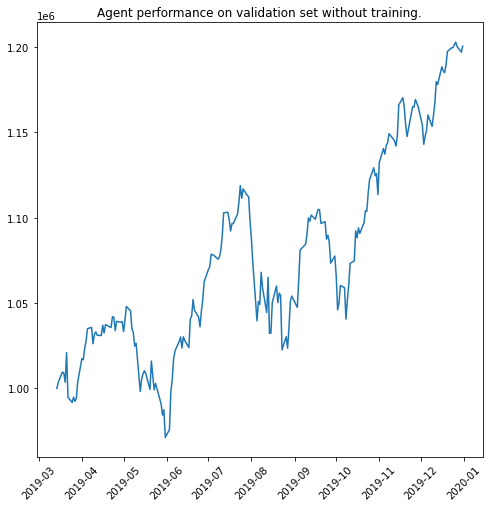

Initial value of portfolio:  1000000.0
Final value of portfolio:  1200444.1
Maximum value of portfolio:  1202810.4
Minimum value of portfolio:  971284.06


In [14]:
# Simulate untrained agent to view baseline
loss = agent_loss(validation_env,agent)
plt.figure(figsize=(8,8))
plt.plot(validation_dates[start_idx:], validation_env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title('Agent performance on validation set without training.')
plt.show()
portfolio_vals = validation_env.portfolio_value_hist
print('Initial value of portfolio: ',portfolio_vals[0].numpy())
print('Final value of portfolio: ', portfolio_vals[-1].numpy())
print('Maximum value of portfolio: ',max(portfolio_vals).numpy())
print('Minimum value of portfolio: ',min(portfolio_vals).numpy())

## Agent training

#### Training step

In [15]:
TRADING_DAYS_PER_YEAR = 253

def train_step(agent,batch):
    """Runs a model training step."""
    env = TradingEnv(batch,train_noise=0.2)
 
    with tf.GradientTape() as tape:
        tape.watch(agent.model.trainable_variables)
        loss = agent_training_loss(env,agent,dsct = 0.999)

        grad = tape.gradient(loss,agent.model.trainable_variables)
    
    grad = [g / tf.reduce_mean(tf.abs(g)) for g in grad]
    agent.opt.apply_gradients(zip(grad,agent.model.trainable_variables))

    reward = -TRADING_DAYS_PER_YEAR * loss/(env._end_tick-env._start_tick)

    return reward


#### Early stopping 
In case of drop in performance

In [16]:
def Callback_EarlyStopping(RewardsList, min_delta=0, patience=3):
    
    if RewardsList[-1] != RewardsList[-1]:
        print('NAN error')
        return True   


    #No early stopping for 3*patience epochs 
    if len(RewardsList)//patience < 3 :
        return False
    #Mean loss for last patience epochs and second-last patience epochs
    mean_previous = np.mean(RewardsList[::-1][2*patience:3*patience]) #third-last
    mean_recent = np.mean(RewardsList[::-1][:patience]) #last
    #you can use relative or absolute change
    delta = mean_recent - mean_previous # change
    percent_delta = delta / mean_previous  # relative change
    if percent_delta < min_delta : 
        print(f"*CB_ES* Percent change in reward value: {percent_delta*1e2:.4f}")
        return True 
    else:
        return False

#### Training Loop

In [17]:
train_avg_rewards = []
val_avg_rewards = []
MAX_EPOCHS = 75
VALIDATION_SAMPLES = 1
PATIENCE = 5
best_val_reward = 0 

# Select a training batch to track progress on training 
for epoch in tqdm(range(MAX_EPOCHS)):
    training_rewards = []
    for batch in batched_training_data:
    
        reward = train_step(agent,batch)
        
        training_rewards.append(reward)

    # Find avg reward for training batch on current epoch
    train_avg_rewards.append(np.mean(training_rewards))
    # Find avg reward for validation data on current epoch
    sar = sampled_agent_reward(TradingEnv,validation_data,[agent],NUM_STOCKS,VALIDATION_SAMPLES,dsct = 1)
    val_avg_rewards.append(np.mean(sar[agent.name]))
    
    clear_output(wait=True)
    display(f'Epoch: {epoch+1}')
    display(f'Training return. Current: {train_avg_rewards[-1]:.4f}. Average: {np.mean(train_avg_rewards):.4f}.')
    display(f'Validation return: {val_avg_rewards[-1]:.4f}. Average: {np.mean(val_avg_rewards):.4f}.')

        

    if Callback_EarlyStopping(val_avg_rewards, patience=PATIENCE):
        break


'Epoch: 60'

'Training return. Current: 0.1507. Average: 0.0835.'

'Validation return: 0.4016. Average: 0.3164.'

100%|██████████| 60/60 [23:35<00:00, 23.59s/it]


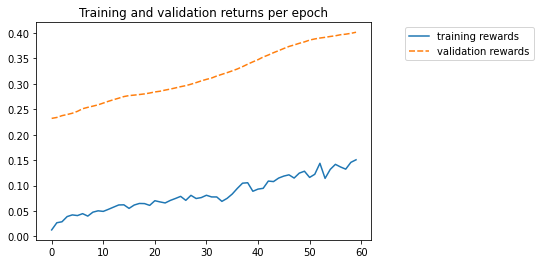

In [18]:
df = pd.DataFrame({'training rewards':train_avg_rewards,'validation rewards':val_avg_rewards})

sns.lineplot( data = df)
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1) )
plt.title("Training and validation returns per epoch")
plt.show()

Note that validation values are significantly higher than training values. This would seem strange, however, in this case data in the validation set does not have the same distribution as data from the training set, which is why we see higher returns in the validation set.

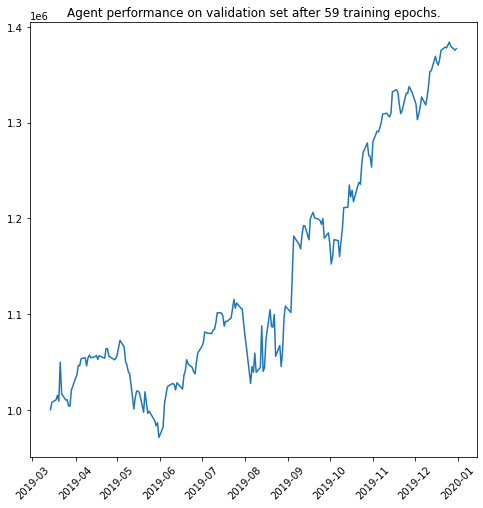

Initial value of portfolio:  1000000.0
Final value of portfolio:  1377330.6
Maximum value of portfolio:  1384163.4
Minimum value of portfolio:  970937.06


In [19]:
# Simulate trained agent to view behavior after training
loss = agent_loss(validation_env,agent)
plt.figure(figsize=(8,8))
plt.plot(validation_dates[start_idx:], validation_env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title(f'Agent performance on validation set after {epoch} training epochs.')
plt.show()
print('Initial value of portfolio: ',validation_env.portfolio_value_hist[0].numpy())
print('Final value of portfolio: ',validation_env.portfolio_value_hist[-1].numpy())
print('Maximum value of portfolio: ',max(validation_env.portfolio_value_hist).numpy())
print('Minimum value of portfolio: ',min(validation_env.portfolio_value_hist).numpy())

#### Save model

In [26]:

with open('dpm_agent_trained.dill','wb') as dill_file:
    dill.dump(agent, dill_file)